In [1]:
# Uncomment the following line to install the required packages if not already installed
# !pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc

# Quantum Walks and Monte Carlo

## Part I - Universal Statistical Simulator Understanding

The 2-pager description of the approach to achieve various distributions with Quantum Galton Board can be found here: [solution summary](solution_summary.md).

## Part II - General Algorithm for Quantum Galton Box

In [2]:
from typing import List, Dict, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_ibm_runtime import SamplerV2 as IBMASampler
from qiskit.providers import BackendV2

In [3]:
SHOTS = 2048
ENABLE_REAL_DEVICE = False

In [4]:
def create_gaussian(n, shots):
    left = -(n / 2)
    right = left + n + 1
    positions = np.arange(left, right)
    mean = 0
    std = np.sqrt(n)
    gaussian = np.exp(-0.5 * ((2 * positions - mean) / std) ** 2)
    gaussian /= gaussian.sum()
    gaussian *= shots
    return positions, gaussian

In [5]:
def calculate_wire_tuples(n, level, shift=0) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i + shift, i + shift + 1) for i in range(middle - level, middle + level)]

In [6]:
def run_circuit(
    circuit_generator,
    n,
    coin_function,
    simulator: bool = True,
    optimization_level: int = 1,
    backend: None | BackendV2 = None,
    noise_model: None | NoiseModel = None,
    shots: int = SHOTS,
    **kwargs,
) -> Dict[str, int]:
    my_circuit = circuit_generator(n, coin=coin_function, **kwargs)
    if simulator:
        backend = AerSimulator()
        if noise_model is None:
            sampler = AerSampler()
        else:
            sampler = AerSampler(
                options=dict(backend_options=dict(noise_model=noise_model))
            )
    else:
        if backend is None:
            raise ValueError("Backend must be specified for non-simulator runs.")
        sampler = IBMASampler(mode=backend)
    print(f"Running circuit on {backend.name}")
    print(
        f"Simulator: {simulator}, Optimization Level: {optimization_level}; Noise Model: {noise_model}"
    )
    pass_manager = generate_preset_pass_manager(
        optimization_level=optimization_level, backend=backend
    )
    isa_qgb_circuit = pass_manager.run(my_circuit)
    job = sampler.run([isa_qgb_circuit], shots=shots)
    result = job.result()[0]
    freqs = result.data.distribution.get_counts()
    print(f"Freqs from sampler: {freqs}")
    print(f"Total counts: {sum(freqs.values())}")
    for i in range(0, n + 1):
        bits = ["0"] * (n + 1)
        bits[i] = "1"
        bitstring = "".join(bits)
        if bitstring not in freqs:
            freqs[bitstring] = 0
    freqs = dict(sorted(freqs.items()))
    return freqs


def plot_freqs(n, freqs, title="", x_map=None, reference_values=None):
    """Plots the frequencies of bitstrings as a histogram, with optional reference line."""
    if len(freqs) != n + 1:
        print("Warning: The number of frequencies does not match the expected count.")
        return
    if x_map is not None:
        if len(x_map) != n + 1:
            print("Warning: x_map length does not match the expected count.")
            return
        x_axis = x_map
    else:
        x_axis = list(freqs.keys())
    plt.bar(x_axis, freqs.values(), label="Quantum Galton Box")
    if reference_values is not None:
        plt.plot(
            x_axis,
            reference_values,
            color="red",
            marker="o",
            linestyle="-",
            label="Reference",
        )
    plt.xlabel("Bitstring")
    plt.ylabel("Frequency")
    plt.title(title)
    if reference_values is not None:
        plt.legend()
    plt.show()

def cleanup_freqs(freqs: Dict[str, int], n: int, shots: int=SHOTS) -> Dict[str, int]:
    """Cleans up the frequency dictionary to ensure all bitstrings are present."""
    new_freqs = {}
    for i in range(0, n + 1):
        bits = ["0"] * (n + 1)
        bits[i] = "1"
        bitstring = "".join(bits)
        new_freqs[bitstring] = freqs.get(bitstring, 0)
    new_freqs = dict(sorted(new_freqs.items()))
    total_counts = sum(new_freqs.values())
    if total_counts < shots:
        ratio = shots / total_counts
        for key in new_freqs:
            new_freqs[key] = int(new_freqs[key] * ratio)
    return new_freqs

In [7]:
def create_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, wire_tuples=calculate_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(2 * n + 2)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    measures(circuit)
    return circuit

In [8]:
def hadamard_coin(qc: QuantumCircuit, n: int, level: int):
    """Applies a Hadamard coin operation for the Quantum Galton Board."""
    qc.h(0)

def double_hadamard_coin(qc: QuantumCircuit, n: int, level: int):
    """Applies a Hadamard coin operation for the Quantum Galton Board."""
    qc.h(0)
    qc.h(1)

Running circuit on aer_simulator
Simulator: True, Optimization Level: 1; Noise Model: None
Freqs from sampler: {'000000100': 253, '000010000': 532, '000100000': 433, '000001000': 451, '000000010': 62, '001000000': 220, '010000000': 81, '000000001': 7, '100000000': 9}
Total counts: 2048


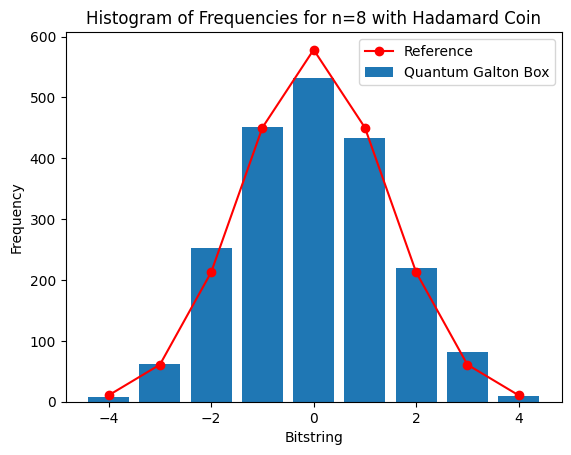

In [9]:
n = 8
positions, gaussian = create_gaussian(n, SHOTS)
freqs = run_circuit(create_qgb_circuit, n, hadamard_coin)
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Hadamard Coin",
    x_map=list(positions),
    reference_values=gaussian,
)

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

Running circuit on aer_simulator
Simulator: True, Optimization Level: 1; Noise Model: None
Freqs from sampler: {'00000100': 630, '00000001': 273, '00010000': 117, '00001000': 358, '00000010': 643, '00100000': 25, '01000000': 2}
Total counts: 2048


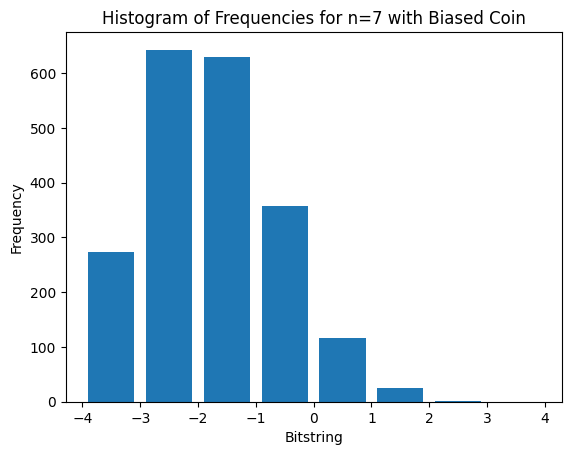

In [10]:
n = 7
left = -(n / 2)
right = left + n + 1
positions = np.arange(left, right)

coin_function = lambda qc, n, level: qc.ry(2 * np.pi / 3, 0)
freqs = run_circuit(create_qgb_circuit, n, coin_function)
plot_freqs(
    n,
    freqs,
    x_map=list(positions),
    title=f"Histogram of Frequencies for n={n} with Biased Coin",
)

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [11]:
def exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qc.cx(i, 0)
        qc.cry(theta, middle + level - 1, 0)

Running circuit on aer_simulator
Simulator: True, Optimization Level: 1; Noise Model: None
Freqs from sampler: {'000001': 1314, '000010': 450, '001000': 71, '000100': 179, '100000': 9, '010000': 25}
Total counts: 2048


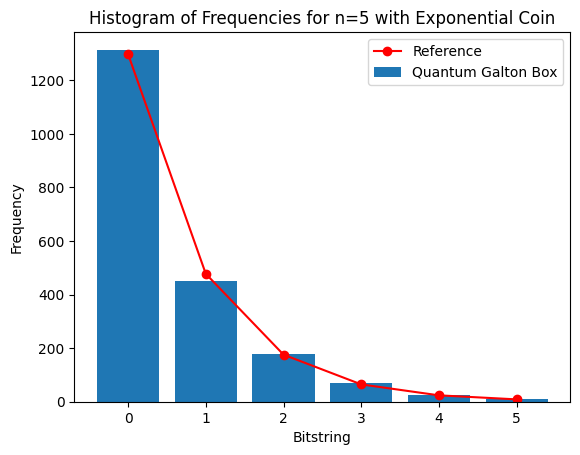

In [12]:
n = 5

x = np.arange(0, n + 1)
lambda_rate = 1
reference_freqs = np.exp(-lambda_rate * x)
reference_freqs /= reference_freqs.sum()
reference_freqs *= SHOTS

freqs = run_circuit(create_qgb_circuit, n, exponential_coin)
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Exponential Coin",
    x_map=list(x),
    reference_values=reference_freqs,
)

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [13]:
def reference_hadamard_distribution(num_steps):
    hadamard = lambda: np.array([[1, 1], [1, -1]]) / np.sqrt(2)

    position_range = 2 * num_steps + 1
    mid = position_range // 2
    state = np.zeros((2, position_range), dtype=complex)
    state[:, mid] = np.array([1, 1j])
    H = hadamard()
    for _ in range(num_steps):
        coin_transformed = np.zeros_like(state, dtype=complex)
        for pos in range(position_range):
            coin_state = state[:, pos]
            coin_transformed[:, pos] = H @ coin_state
        new_state = np.zeros_like(state, dtype=complex)
        for pos in range(position_range):
            for coin in [0, 1]:
                shift = -1 if coin == 0 else 1
                new_pos = pos + shift
                if 0 <= new_pos < position_range:
                    new_state[coin, new_pos] += coin_transformed[coin, pos]
        state = new_state
    total_prob = np.sum(np.abs(state) ** 2)
    probabilities = np.sum(np.abs(state) ** 2, axis=0) / total_prob
    positions = np.arange(-num_steps, num_steps + 1)
    return positions, probabilities

In [14]:
def calculate_hrw_wire_tuples(n, level, shift=0) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i + shift, i + shift + 1) for i in range(middle - level, middle + level)]


def calculate_hrw_fs_wire_tuples(n) -> List[Tuple[int, int]]:
    iterations = math.floor((n + 1) / 2)
    return [(i * 2 + 1, 2 * n + 2 - (i * 2) - 1) for i in range(iterations)]


def create_hrw_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples):
        control_value = 0
        print(len(wire_tuples))
        for wires in wire_tuples:
            qc.cswap(0, wires[0], wires[1], ctrl_state=control_value)
            control_value ^= 1

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_hrw_wire_tuples(n, level))
            qc.barrier()

    def final_swap(qc: QuantumCircuit):
        qc.reset(0)
        qc.h(0)
        for wires in calculate_hrw_fs_wire_tuples(n):
            qc.cswap(0, wires[0], wires[1])
        qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(2 * n + 2)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    final_swap(circuit)
    measures(circuit)
    return circuit

2
4
6
8
10
12
14
16
Running circuit on aer_simulator
Simulator: True, Optimization Level: 1; Noise Model: None
Freqs from sampler: {'001000000': 466, '000000100': 476, '010000000': 284, '000001000': 161, '000100000': 180, '000010000': 160, '000000010': 309, '000000001': 6, '100000000': 6}
Total counts: 2048


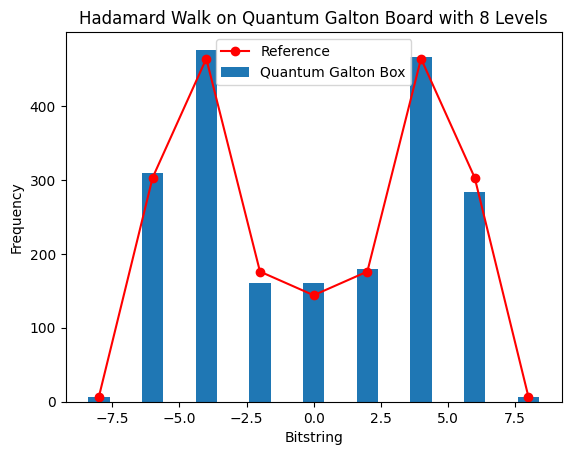

In [15]:
n = 8
freqs = run_circuit(create_hrw_qgb_circuit, n, hadamard_coin)
positions, reference_probs = reference_hadamard_distribution(n)
reference_freqs = [int(rf) for rf in reference_probs[::2] * SHOTS]
plot_freqs(
    n,
    freqs,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
    x_map=list(positions[::2]),
    reference_values=reference_freqs,
)

2
4


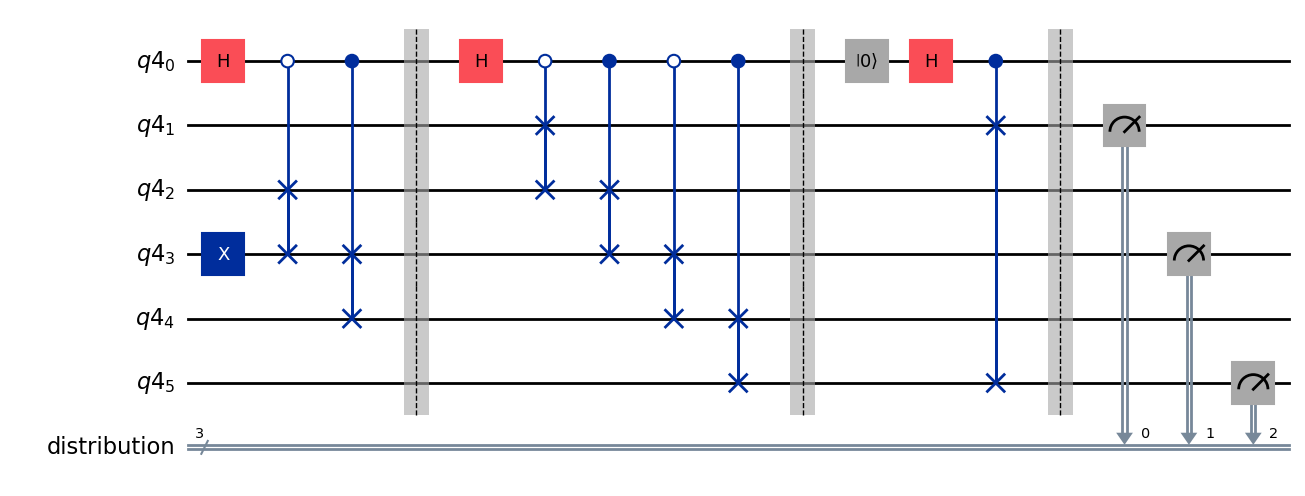

In [16]:
circuit = create_hrw_qgb_circuit(2, hadamard_coin)
circuit.draw("mpl")

## Part IV - Optimization under Noise Models

Having our implementation working on the noiseless simulators, we will now work on exploring the circuit under a noise model.

Pennylane allows loading noise models from Qiskit's IBM backends. We will use this feature to assist in the effort of optimizing the circuits (maximazing the accuracy and number of Galton board layers).

In [17]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeTorino

service = QiskitRuntimeService()
real_torino = service.backend("ibm_torino")
fake_torino = FakeTorino()
print(fake_torino.num_qubits)
torino_noise_model = NoiseModel.from_backend(real_torino)
# least_busy_backend = service.least_busy()

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-22 22:25:33,757: Default instance not set. Searching all available instances.


133


### Exponential Distribution

In [18]:
# Classiq implementation
# repeat(q.len, lambda i: RY(2.0 * atan(exp((-rate * 2.0**i) / 2.0)), q[i]))
def prep_exponential(n, rate) -> QuantumCircuit:
    """Prepare exponential distribution on n qubits."""
    circuit = QuantumCircuit(n, n)
    for i in range(n):
        circuit.ry(2.0 * math.atan(math.exp((-rate * 2.0**i) / 2.0)), i)
    circuit.measure(range(n), range(n))
    return circuit

In [19]:
def optimized_exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        qc.cry(theta, level + 1, 0)

In [20]:
def calculate_exp_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    return [(i, i + 1) for i in range(level, level+2)]

In [21]:
def create_exp_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(2)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, wire_tuples=calculate_exp_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(list(range(1, n + 1)) + [n + 2]):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(n + 3)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    measures(circuit)
    return circuit

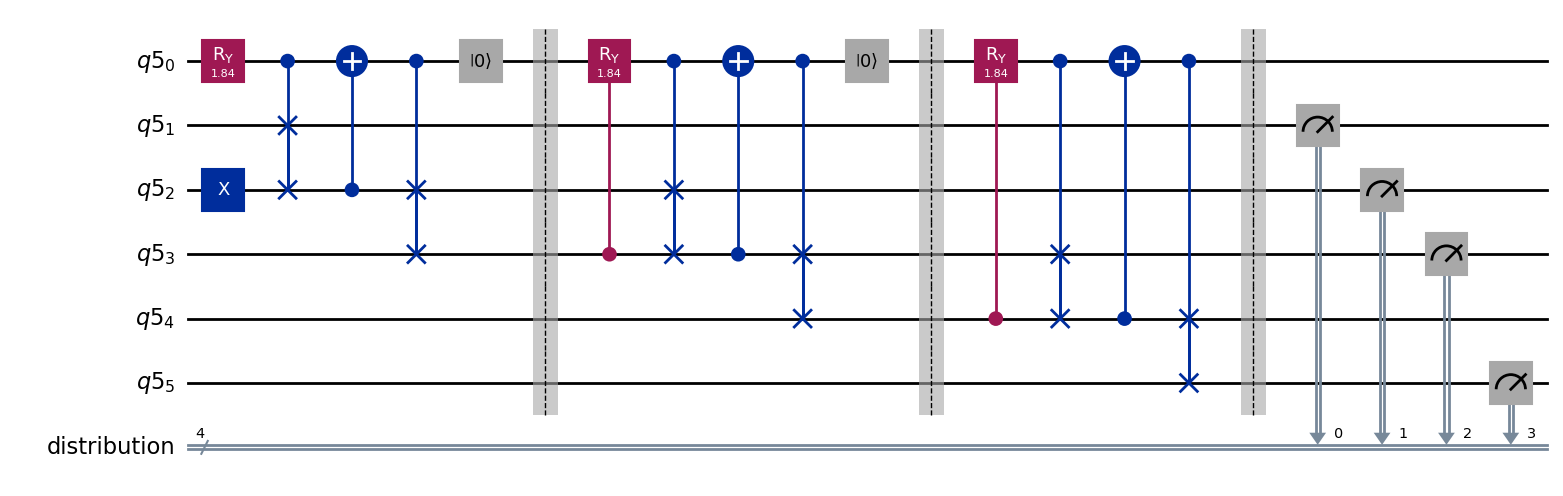

In [22]:
n = 3
exp_circuit = create_exp_qgb_circuit(n, optimized_exponential_coin)
exp_circuit.draw("mpl")

Let's now test drive our optimized circuit.

Running circuit on aer_simulator
Simulator: True, Optimization Level: 1; Noise Model: NoiseModel:
  Basis gates: ['cz', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'x', 'reset', 'sx', 'id', 'cz']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('x', (7,)), ('x', (8,)), ('x', (9,)), ('x', (10,)), ('x', (11,

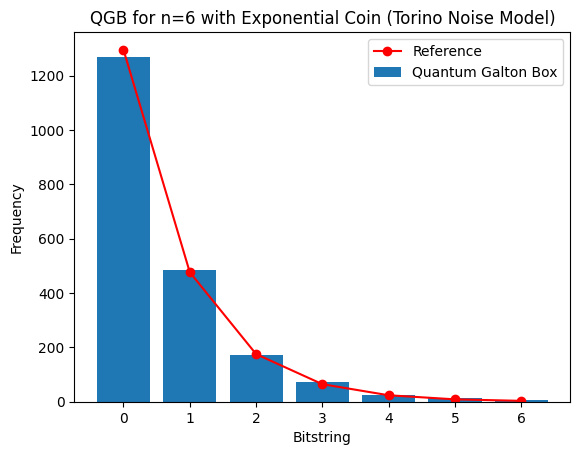

In [23]:
n = 6
x = np.arange(0, n + 1)
lambda_rate = 1
reference_freqs = np.exp(-lambda_rate * x)
reference_freqs /= reference_freqs.sum()
reference_freqs *= SHOTS
freqs = cleanup_freqs(
    run_circuit(
        create_exp_qgb_circuit,
        n,
        optimized_exponential_coin,
        noise_model=torino_noise_model,
    ),
    n,
)
plot_freqs(
    n,
    freqs,
    title=f"QGB for n={n} with Exponential Coin (Torino Noise Model)",
    x_map=list(x),
    reference_values=reference_freqs,
)

#### Real Hardware

Running circuit on fake_torino
Simulator: False, Optimization Level: 3; Noise Model: None
Freqs from sampler: {'000101': 144, '000001': 3200, '110100': 13, '000100': 528, '001000': 196, '010001': 201, '001101': 110, '000111': 102, '000010': 1300, '000011': 166, '011000': 33, '100001': 349, '010000': 85, '001001': 208, '011001': 147, '110001': 76, '001100': 57, '100000': 60, '101111': 4, '100010': 127, '001010': 101, '010011': 20, '010100': 35, '000000': 174, '001110': 41, '011100': 23, '010010': 88, '001011': 25, '000110': 102, '011010': 51, '100111': 10, '110010': 32, '100100': 49, '101010': 18, '100101': 31, '101001': 44, '010101': 21, '010110': 14, '001111': 12, '011111': 5, '111100': 6, '100011': 14, '101000': 22, '111000': 8, '110110': 6, '011101': 18, '101101': 10, '110000': 11, '111101': 2, '110111': 1, '101100': 12, '011110': 7, '111001': 17, '010111': 8, '101110': 2, '100110': 14, '111010': 4, '111011': 2, '110101': 10, '110011': 10, '111110': 1, '011011': 3, '101011': 2}
Tota

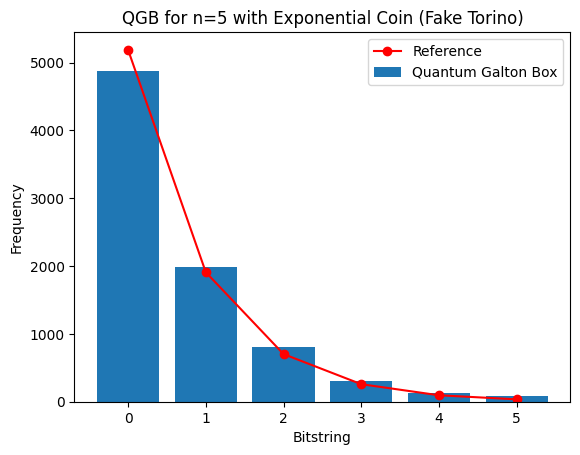

In [24]:
shots = 8192
n = 5
x = np.arange(0, n + 1)
lambda_rate = 1
reference_freqs = np.exp(-lambda_rate * x)
reference_freqs /= reference_freqs.sum()
reference_freqs *= shots
freqs = cleanup_freqs(
    run_circuit(
        create_exp_qgb_circuit,
        n,
        optimized_exponential_coin,
        simulator=False,
        optimization_level=3,
        backend=fake_torino,
        shots=shots,
    ),
    n,
    shots=shots,
)
plot_freqs(
    n,
    freqs,
    title=f"QGB for n={n} with Exponential Coin (Fake Torino)",
    x_map=list(x),
    reference_values=reference_freqs,
)

Let's run the same workload on Real backend

In [25]:
if ENABLE_REAL_DEVICE:
    shots = 2048
    n = 7
    x = np.arange(0, n + 1)
    lambda_rate = 1
    reference_freqs = np.exp(-lambda_rate * x)
    reference_freqs /= reference_freqs.sum()
    reference_freqs *= shots
    freqs = cleanup_freqs(
        run_circuit(
            create_exp_qgb_circuit,
            n,
            optimized_exponential_coin,
            simulator=False,
            optimization_level=3,
            backend=real_torino,
            shots=shots,
        ),
        n,
        shots=shots,
    )
    plot_freqs(
        n,
        freqs,
        title=f"QGB for n={n} with Exponential Coin (Real Torino)",
        x_map=list(x),
        reference_values=reference_freqs,
    )

### Hadamard Random Walk

2
4
6
8
Running circuit on aer_simulator
Simulator: True, Optimization Level: 1; Noise Model: NoiseModel:
  Basis gates: ['cz', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'x', 'reset', 'sx', 'id', 'cz']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('x', (7,)), ('x', (8,)), ('x', (9,)), ('x', (10,)), ('

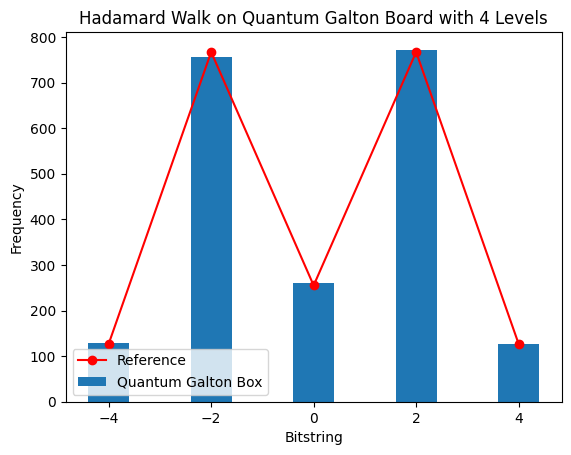

In [26]:
n = 4
freqs = cleanup_freqs(
    run_circuit(
        create_hrw_qgb_circuit, n, hadamard_coin, noise_model=torino_noise_model
    ),
    n,
)
positions, reference_probs = reference_hadamard_distribution(n)
hrw_reference_freqs = [int(rf) for rf in reference_probs[::2] * SHOTS]
plot_freqs(
    n,
    freqs,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
    x_map=list(positions[::2]),
    reference_values=hrw_reference_freqs,
)

#### Real Hardware

2
4
6
8
Running circuit on fake_torino
Simulator: False, Optimization Level: 3; Noise Model: None
Freqs from sampler: {'00000': 293, '01000': 278, '11000': 56, '10100': 30, '00010': 282, '00100': 249, '10010': 32, '00110': 96, '00001': 73, '01100': 108, '01101': 18, '10001': 19, '10000': 84, '01010': 90, '11001': 14, '11110': 13, '01011': 21, '00011': 47, '11010': 19, '01001': 29, '01110': 52, '11111': 3, '00111': 18, '00101': 39, '10110': 20, '10011': 9, '11011': 5, '11100': 28, '11101': 6, '10101': 8, '01111': 6, '10111': 3}
Total counts: 2048


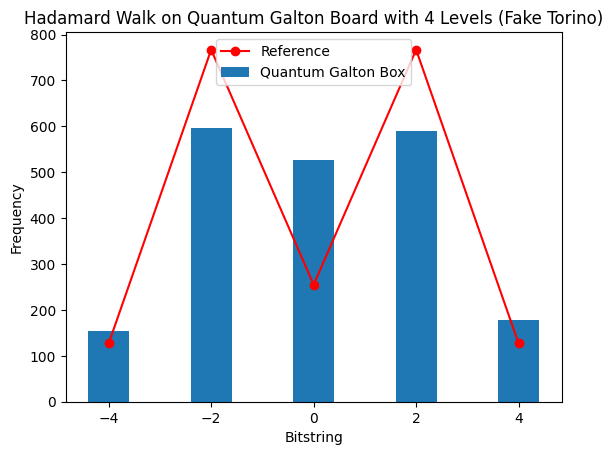

In [27]:
n = 4
freqs = cleanup_freqs(
    run_circuit(
        create_hrw_qgb_circuit,
        n,
        hadamard_coin,
        simulator=False,
        optimization_level=3,
        backend=fake_torino,
    ),
    n,
)
positions, reference_probs = reference_hadamard_distribution(n)
hrw_reference_freqs = [int(rf) for rf in reference_probs[::2] * SHOTS]
plot_freqs(
    n,
    freqs,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels (Fake Torino)",
    x_map=list(positions[::2]),
    reference_values=hrw_reference_freqs,
)

In [28]:
freqs = run_circuit(
    create_hrw_qgb_circuit,
    n,
    hadamard_coin,
    simulator=False,
    optimization_level=3,
    backend=fake_torino,
)


2
4
6
8
Running circuit on fake_torino
Simulator: False, Optimization Level: 3; Noise Model: None
Freqs from sampler: {'01010': 86, '00010': 248, '01011': 17, '10100': 57, '00001': 80, '00110': 102, '00000': 258, '10101': 11, '10000': 87, '10010': 40, '00011': 55, '01100': 129, '01000': 264, '00100': 238, '01101': 22, '01110': 52, '00111': 28, '10011': 8, '00101': 38, '01001': 37, '11101': 7, '11100': 27, '10001': 25, '01111': 8, '10110': 19, '11000': 49, '11110': 9, '11001': 7, '11111': 5, '10111': 9, '11010': 22, '11011': 4}
Total counts: 2048


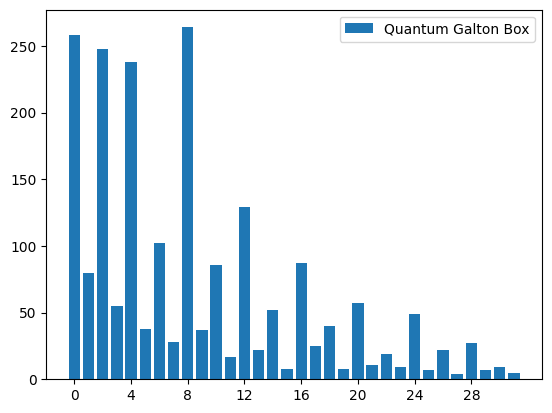

In [29]:
plt.bar([int(b, 2) for b in freqs.keys()], freqs.values(), label="Quantum Galton Box")
plt.xticks(np.arange(0, 2**(n + 1), step=4))
plt.legend()
plt.show()


Let's now run Hadamard Random Walk on real hardware.

In [30]:
if ENABLE_REAL_DEVICE:
    n = 5
    freqs = cleanup_freqs(
        run_circuit(
            create_hrw_qgb_circuit,
            n,
            hadamard_coin,
            simulator=False,
            optimization_level=3,
            backend=real_torino,
        ),
        n,
    )
    positions, reference_probs = reference_hadamard_distribution(n)
    hrw_reference_freqs = [int(rf) for rf in reference_probs[::2] * SHOTS]
    plot_freqs(
        n,
        freqs,
        title=f"Hadamard Walk on Quantum Galton Board with {n} Levels (Real Torino)",
        x_map=list(positions[::2]),
        reference_values=hrw_reference_freqs,
    )

## Part V - Study the Distances between Obtained and Target Distributions

Let's now turn to understanding how well the obtained distributions are approximating the target distributions.

We have collected a hefty amount of samples for both Exponential and Hadamard Random Walk circuits executed under the noise model.

In [31]:
freqs = {
    "000000": 173,
    "111000": 9,
    "000010": 190,
    "000111": 49,
    "001010": 106,
    "111011": 4,
    "011110": 33,
    "001000": 95,
    "100110": 17,
    "000110": 183,
    "000100": 154,
    "000001": 69,
    "001100": 77,
    "001111": 40,
    "011010": 39,
    "010000": 37,
    "000011": 72,
    "100001": 8,
    "001001": 25,
    "101100": 6,
    "001110": 97,
    "000101": 37,
    "011001": 10,
    "001011": 37,
    "010010": 39,
    "111100": 4,
    "001101": 28,
    "011000": 37,
    "110010": 10,
    "011101": 18,
    "110110": 7,
    "010100": 40,
    "010101": 11,
    "010001": 9,
    "010110": 33,
    "110011": 5,
    "101101": 4,
    "100010": 15,
    "111001": 4,
    "101000": 10,
    "111101": 1,
    "110001": 3,
    "010111": 16,
    "100000": 19,
    "110000": 11,
    "011100": 26,
    "100100": 15,
    "101010": 12,
    "100111": 4,
    "011111": 4,
    "100011": 10,
    "011011": 12,
    "101110": 15,
    "110111": 5,
    "111111": 2,
    "110100": 9,
    "111010": 5,
    "101111": 8,
    "010011": 18,
    "101011": 2,
    "111110": 2,
    "100101": 3,
    "101001": 4,
    "110101": 1,
}

In [32]:
n = 5


def get_ones_indices(s: str) -> List[int]:
    """Returns the indices of '1's in the bitstring."""
    return [i for i, c in enumerate(s) if c == "1"]


new_freqs = {f"{2**i:0{n+1}b}": 0 for i in range(n + 1)}
for bitstring, count in freqs.items():
    indices = get_ones_indices(bitstring)
    if len(indices) == 0:
        indices = list(range(n + 1))  # If no '1's, consider all indices
    fraction = count / len(indices)
    for i in indices:
        new_freqs[f"{2**(n-i):0{n+1}b}"] += fraction
total_counts = sum(new_freqs.values())
if total_counts < SHOTS:
    ratio = SHOTS / total_counts
    for key in new_freqs:
        new_freqs[key] = int(new_freqs[key] * ratio)
print(new_freqs)

{'000001': 262, '000010': 573, '000100': 491, '001000': 379, '010000': 219, '100000': 122}


<BarContainer object of 6 artists>

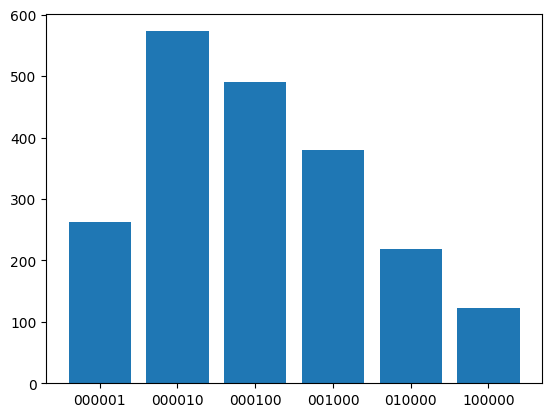

In [33]:
plt.bar(new_freqs.keys(), new_freqs.values(), label="Quantum Galton Box")

#### Gaussian on noisy simulator

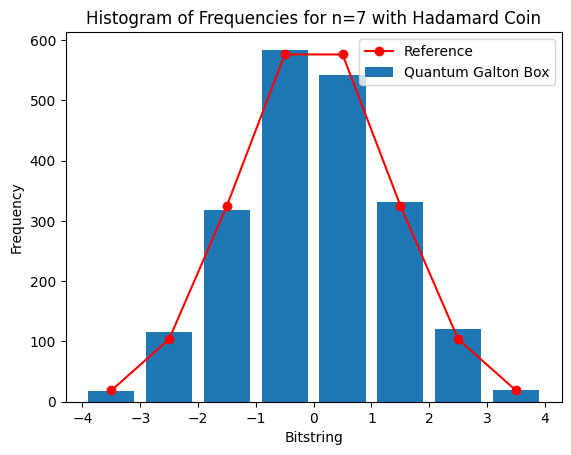

In [34]:
n = 7
qc = create_qgb_circuit(n, hadamard_coin)
simulator = AerSimulator()
# simulator = AerSimulator(method='statevector')
# simulator = AerSimulator.from_backend(real_torino)

compiled_circuit = transpile(qc, simulator, optimization_level=3)
job = simulator.run([compiled_circuit], shots=SHOTS) # Execute the circuit
result = job.result()

freqs = result.get_counts()
for i in range(0, n + 1):
    bits = ["0"] * (n + 1)
    bits[i] = "1"
    bitstring = "".join(bits)
    if bitstring not in freqs:
        freqs[bitstring] = 0
freqs = cleanup_freqs(dict(sorted(freqs.items())),  n, SHOTS)
positions, gaussian = create_gaussian(n, SHOTS)
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Hadamard Coin",
    x_map=list(positions),
    reference_values=gaussian,
)

#### Exponential on noisy simulator

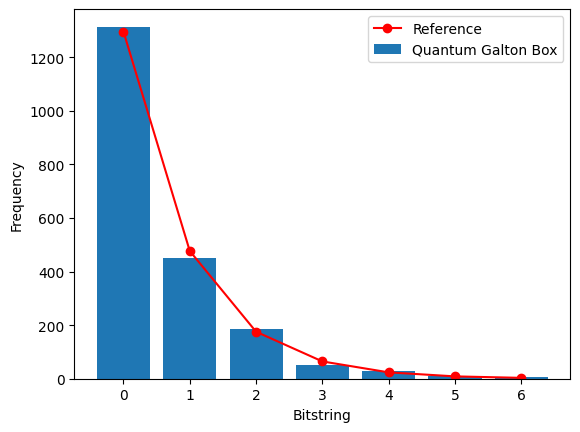

In [35]:
n = 6
qc = create_exp_qgb_circuit(n, optimized_exponential_coin)

simulator = AerSimulator(method='statevector')
# simulator = AerSimulator.from_backend(real_torino)

compiled_circuit = transpile(qc, simulator, optimization_level=3)
job = simulator.run([compiled_circuit], shots=SHOTS) # Execute the circuit
result = job.result()

freqs = result.get_counts()
for i in range(0, n + 1):
    bits = ["0"] * (n + 1)
    bits[i] = "1"
    bitstring = "".join(bits)
    if bitstring not in freqs:
        freqs[bitstring] = 0
freqs = cleanup_freqs(dict(sorted(freqs.items())),  n, SHOTS)
x = np.arange(0, n + 1)
lambda_rate = 1
reference_freqs = np.exp(-lambda_rate * x)
reference_freqs /= reference_freqs.sum()
reference_freqs *= SHOTS
plot_freqs(n, freqs, x_map=x, reference_values=reference_freqs)

#### Hadamard Random Walk on noisy simulator

2
4
6
8
10
12
14
16


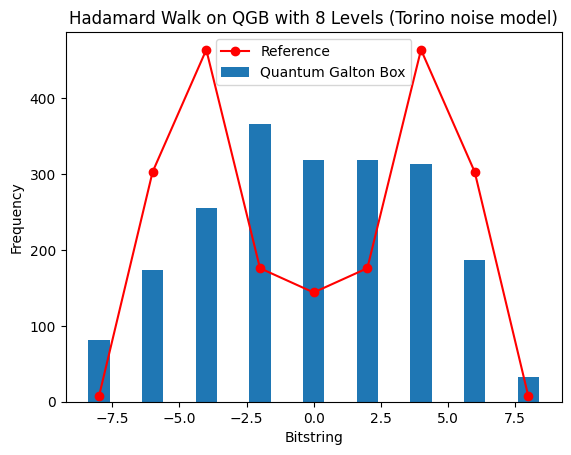

In [77]:
n = 8
qc = create_hrw_qgb_circuit(n, hadamard_coin)

# simulator = AerSimulator(method='statevector')
simulator = AerSimulator.from_backend(real_torino)

compiled_circuit = transpile(qc, simulator, optimization_level=3)
job = simulator.run([compiled_circuit], shots=SHOTS) # Execute the circuit
result = job.result()

freqs = result.get_counts()
for i in range(0, n + 1):
    bits = ["0"] * (n + 1)
    bits[i] = "1"
    bitstring = "".join(bits)
    if bitstring not in freqs:
        freqs[bitstring] = 0
freqs = cleanup_freqs(dict(sorted(freqs.items())),  n, SHOTS)
positions, reference_probs = reference_hadamard_distribution(n)
hrw_reference_freqs = [int(rf) for rf in reference_probs[::2] * SHOTS]
plot_freqs(
    n,
    freqs,
    title=f"Hadamard Walk on QGB with {n} Levels (Torino noise model)",
    x_map=list(positions[::2]),
    reference_values=hrw_reference_freqs,
)

In [63]:
def uniform_distribution_coin(qc: QuantumCircuit, n, level):
    """Applies an appropriate coin rotation based on the level."""
    if level % 2 == 1:
        p = 0.5
    else:
        p = 2 / (n + 3 - level)
    theta = 2 * math.acos(np.sqrt(p))
    opp_theta = 2 * math.asin(np.sqrt(p))
    if level == 1:
        qc.ry(theta, n + 1)
    else:
        if level % 2 == 1:
            for i in range(n - level + 1, n):
                qc.cx(i, n + 1)
            qc.cry(theta, n, n + 1)
        else:
            for i in range(n - level + 1, n - 1):
                qc.cx(i, n + 1)
            qc.cry(theta, n + 2, n + 1)
            qc.cry(opp_theta, n - 1, n + 1)

In [64]:
def calculate_uniform_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    return (
        [(i, i + 1) for i in range(n - level, n)]
        + [(n, n + 2)]
        + [(i, i + 1) for i in range(n + 2, n + 1 + level)]
    )


def create_uniform_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(n + 1, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], n + 1)

    def levels(qc: QuantumCircuit):
        qc.x(n)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, wire_tuples=calculate_uniform_wire_tuples(n, level))
            if level < n:
                qc.reset(n + 1)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(0, n + 1, 2)):
            qc.measure(qbit, cbit)
        for cbit, qbit in enumerate(range(n + 3 - (n % 2), 2 * n + 2, 2), start=cbit + 1):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(2 * n + 2)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    measures(circuit)
    return circuit

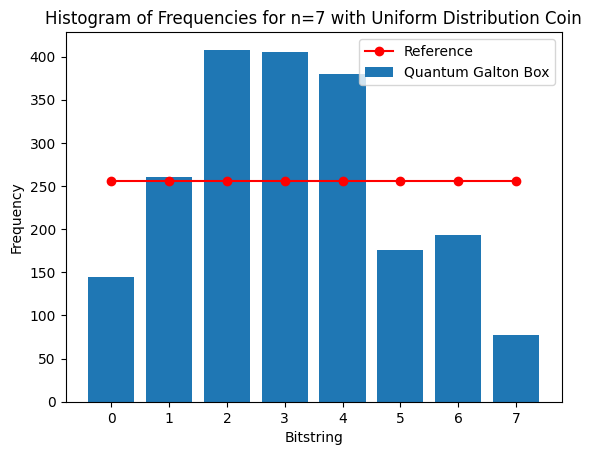

In [76]:
n = 7
qc = create_uniform_qgb_circuit(n, uniform_distribution_coin)
# simulator = AerSimulator()
# simulator = AerSimulator(method='statevector')
simulator = AerSimulator.from_backend(real_torino)

compiled_circuit = transpile(qc, simulator, optimization_level=3)
job = simulator.run([compiled_circuit], shots=SHOTS)  # Execute the circuit
result = job.result()

freqs = result.get_counts()
for i in range(0, n + 1):
    bits = ["0"] * (n + 1)
    bits[i] = "1"
    bitstring = "".join(bits)
    if bitstring not in freqs:
        freqs[bitstring] = 0
freqs = cleanup_freqs(dict(sorted(freqs.items())), n, SHOTS)
positions = list(range(n + 1))
uniform = np.array([1 / (n + 1)] * (n + 1)) * SHOTS
plot_freqs(
    n,
    freqs,
    title=f"Histogram of Frequencies for n={n} with Uniform Distribution Coin",
    x_map=list(positions),
    reference_values=uniform,
)